In [2]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [5]:
import os
from fastgres.analysis_utility.tools.ring_neighborhood_traversal import RingNeighborhoodTraversal
from fastgres.workloads.workload import Workload
from fastgres.baseline.hint_sets import Hint
import random
if os.getcwd() != "C:/Users/Jerome/PycharmProjects/FASTgres":
    os.chdir("C:/Users/Jerome/PycharmProjects/FASTgres")

In [90]:
workload_name = "job"
version = 12.4
a_path = f"fastgres/archives/{workload_name}/{version}/archive.json"
wl_path = f"fastgres/workloads/queries/{workload_name}/"
# wl_path = f"pre_split_queries/stack/context_9"
wl = Workload(wl_path, workload_name)
hints = [hint for hint in Hint]

In [ ]:
# top_k = 5
# config = HintSetOrder.EvaluationConfig(top_k, wl.queries[:50])
# h_o = HintSetOrder(a_path, wl_path, wl.queries, hints)
# h_o.eval_config = config
# # h_o.save_results("figures/hint_set_order_vis/test_c0.pdf")
# h_o.show()

# Hint Order Coverage

In [91]:
from fastgres.analysis_utility.tools.hint_set_order import HintSetOrder
h_o = HintSetOrder(a_path, wl_path, wl.queries, hints)
# top_k_values = [1, 2, 3, 4, 5, 10, 20, 50]
reduced_df = h_o.result_df[h_o.result_df["query_name"].isin(h_o.query_names)]
count_aggregate = reduced_df.groupby(by=[f"level_{i}" for i in range(len(h_o.hints) + 1)]).count()
occ = count_aggregate["time_0"].to_numpy()
top_k_values = [i for i in range(1, 100)] + [len(occ)]
# top_k_values.extend([int(0.005*i*len(h_o.query_names)) for i in range(1, 11)])
coverage = []
for top_k in top_k_values:
    config = h_o.EvaluationConfig(top_k, h_o.query_names)
    h_o.eval_config = config
    coverage.append(h_o.get_top_k_results()["coverage"])
# print(top_k_values)
# print(coverage)

Loading Queries: 113it [00:00, 32502.84it/s]


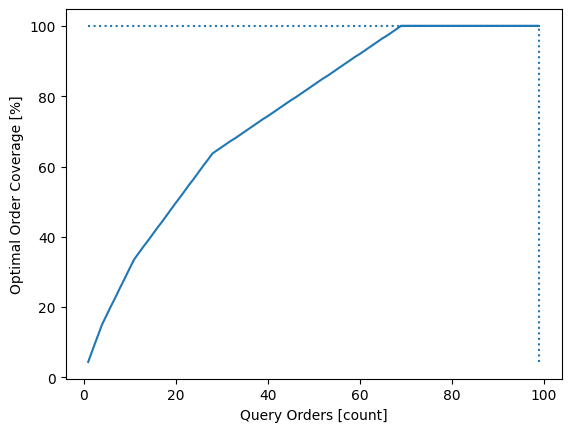

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
fig, ax = plt.subplots()
ax.plot(top_k_values, coverage)
ax.set_xlabel("Query Orders [count]")
ax.set_ylabel("Optimal Order Coverage [%]")
ax.vlines(top_k_values[-2], ymin=min(coverage), ymax=coverage[-2], linestyles="dotted")
ax.hlines(coverage[-2], xmin=min(top_k_values), xmax=top_k_values[-2], linestyles="dotted")
new_yticks = ax.get_yticks()
new_yticks = [_ if _ >= 0.0 else 0.0 for _ in new_yticks]
new_yticks = np.array(list((set(new_yticks) - {100., 120.}).union({coverage[-2]})))
ax.set_yticks(new_yticks)
matplotlib.rcParams['pdf.use14corefonts'] = True
# plt.savefig(f"figures/hint_set_order_vis/order_coverage_{workload_name}.pdf", bbox_inches="tight")
plt.show()

# Optimal Time Deviation

In [93]:
from fastgres.analysis_utility.tools.single_hint_optimization_influence import SingleHintOptimizationInfluence
from fastgres.analysis_utility.tool import TimeGranularity as Tg
from fastgres.analysis_utility import tool

h_o = HintSetOrder(a_path, wl_path, wl.queries, hints, op_mode=RingNeighborhoodTraversal.OperationMode.SUB)
top_k_values = [i for i in range(1, 20)] + [i for i in range(20, 50, 5)] + [i for i in range(50, len(occ), 20)]
sorted_orders = h_o.results["sorted_orders"]

pg_def = [sum(tool.get_baseline(h_o.archive, h_o.query_names)) for _ in top_k_values]
old_opts = default = [sum(tool.get_opt(h_o.archive, h_o.query_names)) for _ in top_k_values]

new_opts = list()
order_size = list()
for top_k in top_k_values:
    order_set = set()
    top_orders = sorted_orders[:top_k]
    for order in top_orders:
        order_set = order_set.union(set(order))
    reduced_archive = tool.get_hint_set_reduced_archive(h_o.archive, list(order_set))
    reduced_archive = tool.get_pseudo_labeled_dict(reduced_archive)
    order_size.append(len(order_set))
    new_opts.append(sum(tool.get_opt(reduced_archive, h_o.query_names)))

old_speedup = tool.get_speedup(pg_def, old_opts)
new_speedup = tool.get_speedup(pg_def, new_opts)
half_index = sum([1 for _ in order_size if _ <= 32]) -1
# print(half_index)
# print(order_size)
# print(old_speedup)
# print(new_speedup)


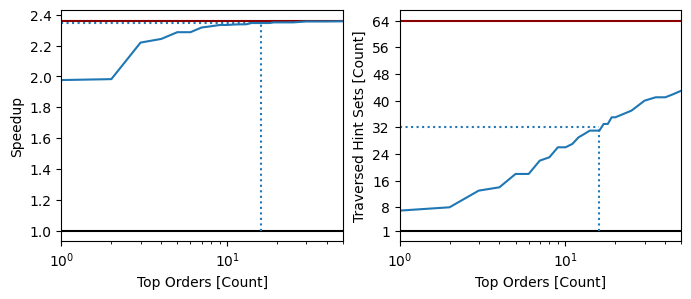

In [94]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

ax[0].plot(top_k_values, old_speedup, color="darkred")
ax[0].hlines(1.0, min(top_k_values), max(top_k_values), color="black")
ax[0].plot(top_k_values, new_speedup)
ax[0].set_xscale("log")
ax[0].set_xlabel("Top Orders [Count]")
ax[0].set_ylabel("Speedup")
# [ax[0].vlines(i, linestyles="dotted", linewidth=.8, alpha=0.1, ymin=1.0, ymax=max(old_speedup)) for i in top_k_values]
ax[0].set_xlim([min(top_k_values), max(top_k_values)])
ax[0].hlines(new_speedup[half_index], xmin=min(top_k_values), xmax = top_k_values[half_index], linestyles="dotted")
ax[0].vlines(top_k_values[half_index], ymin=1.0, ymax = new_speedup[half_index], linestyles="dotted")

ax[1].plot(top_k_values, order_size)
ax[1].plot(top_k_values, [64 for _ in range(len(order_size))], color="darkred")
ax[1].plot(top_k_values, [1 for _ in range(len(order_size))], color="black")
ax[1].set_xscale("log")
ax[1].set_xlabel("Top Orders [Count]")
ax[1].set_ylabel("Traversed Hint Sets [Count]")
ax[1].set_yticks([1] + [i*8 for i in range(1, 9)])
# [ax[1].vlines(i, linestyles="dotted", linewidth=.8, alpha=0.1, ymin=1, ymax=63) for i in top_k_values]
ax[1].set_xlim([min(top_k_values), max(top_k_values)])
ax[1].hlines(32, xmin=min(top_k_values), xmax = top_k_values[half_index], linestyles="dotted")
ax[1].vlines(top_k_values[half_index], ymin=1.0, ymax = 32, linestyles="dotted")

matplotlib.rcParams['pdf.use14corefonts'] = True
# plt.savefig(f"figures/hint_set_order_vis/order_influence_{workload_name}.pdf", bbox_inches="tight")
plt.show()

# Query Order Traversal

Query not in analysis


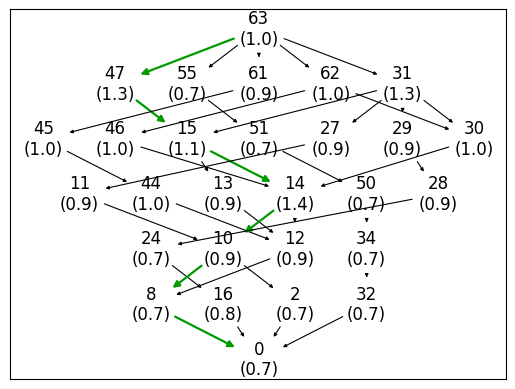

In [96]:
from fastgres.analysis_utility.tools.query_order_traversal import QueryOrderTraversal

q_i = 1
query = wl.queries[q_i:q_i+1]
# query = ["6e.sql"]

factor = 0.1
analysis_queries = wl.queries
random.shuffle(analysis_queries)
analysis_queries = analysis_queries[:int(factor*len(wl.queries))]
try:
    analysis_queries.remove(query)
except ValueError:
    print("Query not in analysis")
    pass

qot = QueryOrderTraversal(a_path, wl_path, analysis_queries, hints, op_mode=QueryOrderTraversal.OperationMode.SUB)
config = QueryOrderTraversal.EvaluationConfig(10, query)
qot.eval_config = config
q_str = str(query[0][:-4][:5])
# qot.save_results(f"figures/hint_set_order_vis/order_influence_{workload_name}_{q_str}.pdf")
qot.show()

# Comparison of FG Default, Heuristic, and Heuristic with Early Stopping

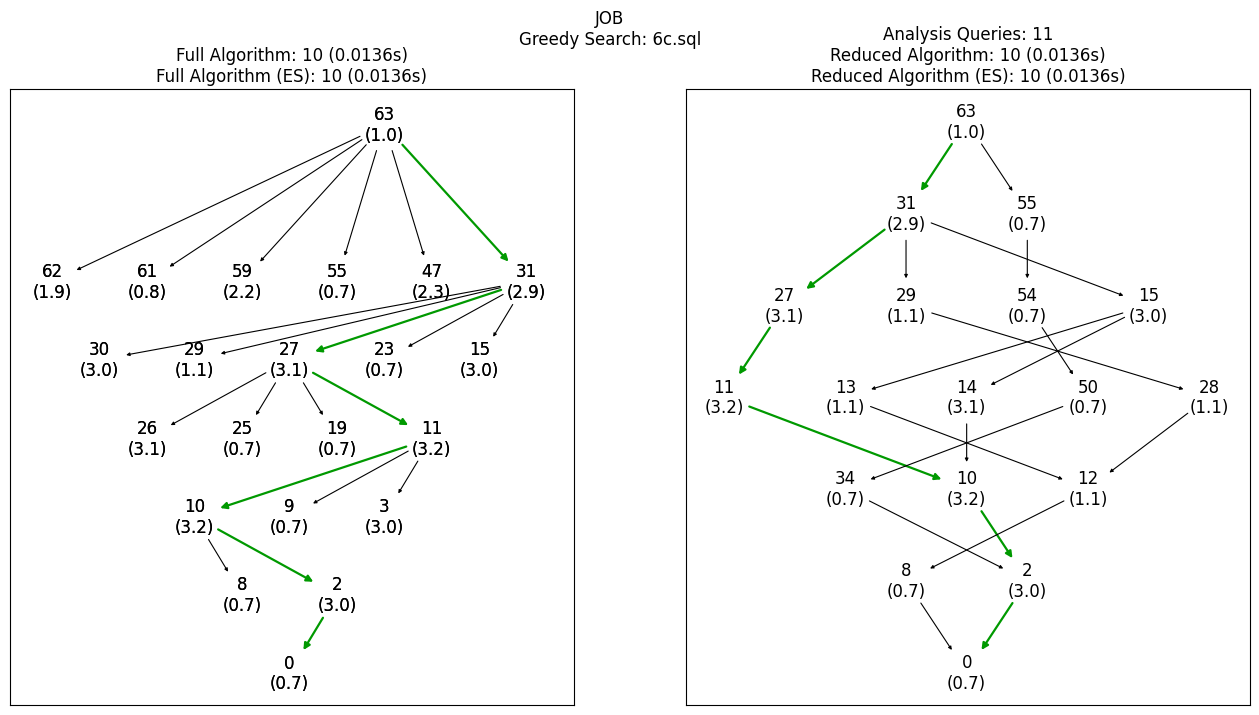

In [103]:
from fastgres.analysis_utility.tools.query_order_traversal import QueryOrderTraversal
from fastgres.analysis_utility import tool
from fastgres.baseline.hint_sets import Hint

def get_hint_set_speedup(a: dict, q_name: str, h_set: int):
    return tool.get_speedup(np.sum(tool.get_baseline(a, [q_name])), np.sum(a[q_name][str(h_set)]))

# q_i = 1
# query = wl.queries[q_i:q_i+1]
# query = ["6e.sql"]

factor = 0.1
analysis_queries = wl.queries
random.shuffle(analysis_queries)
analysis_queries = analysis_queries[:int(factor*len(wl.queries))]

remaining_queries = set(wl.queries) - set(analysis_queries)
remaining_queries = list(remaining_queries)
random.shuffle(remaining_queries)
# query = remaining_queries[q_i:q_i+1]

top_k = 5
qot = QueryOrderTraversal(a_path, wl_path, analysis_queries, hints, op_mode=QueryOrderTraversal.OperationMode.SUB)
pg_def = tool.get_baseline(qot._used_dict, remaining_queries)
opt = tool.get_opt(qot._used_dict, remaining_queries)
orders = dict()
h_o = HintSetOrder(a_path, wl_path, wl.queries, hints, op_mode=QueryOrderTraversal.OperationMode.SUB)

for query_name in remaining_queries:
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    config = QueryOrderTraversal.EvaluationConfig(top_k, [query_name])
    qot.eval_config = config
    max_order = list(qot.get_max_order())
    orders[query_name] = qot.get_best_of_order(query_name, max_order)
    # print(max_order)
    true_hints = [Hint(_) for _ in tool.get_order_from_hint_sets(max_order)]
    reduced_space = {i: set() for i in range(1, len(hints)+1)}
    for order in qot.get_top_k_results()["orders"]:
        for i in range(1, len(order)):
            if max_order[i-1] == order[i-1]:
                reduced_space[i].add(order[i])
        # reduced_space = reduced_space.union(set(order))
    reduced_space = {k: list(v) for k, v in reduced_space.items()}
    traversed_reduced = qot.calculate_one_ring_of_order(true_hints, reduced_space)
    # print(traversed_reduced)
    
    # qot.show()
    ax2 = qot.draw_reduced(ax2)
    
    qot.query_names = [query_name]
    order = list(qot.traverse_hint_sets().keys())
    
    # print(order)
    b1 = qot.get_best_of_order(query_name, order)
    # print(f"Full alg: {b1[0]} {round(b1[1], 4)}s")
    b2 = qot.get_best_of_order(query_name, order, early_stopping=True)
    # print(f"Full alg + es: {b2[0]} {round(b2[1], 4)}s")
    
    # print("\n")
    b3 = qot.get_best_of_order(query_name, max_order)
    # print(f"Reduced alg: {b3[0]} {round(b3[1], 4)}s")
    b4 = qot.get_best_of_order(query_name, max_order, early_stopping=True)
    # print(f"Reduced alg + es: {b4[0]} {round(b4[1], 4)}s")
    ax1 = qot.draw_default(order, ax1)
    default_visits = set(qot.calculate_one_ring_of_order([Hint(i) for i in tool.get_order_from_hint_sets(order)]))
    # print(len(default_visits))
    plt.suptitle(f"{workload_name.upper()}\nGreedy Search: {query_name}")
    ax1.set_title(f"Full Algorithm: {b1[0]} ({round(b1[1], 4)}s)\nFull Algorithm (ES): {b2[0]} ({round(b2[1], 4)}s)")
    ax2.set_title(f"Analysis Queries: {len(analysis_queries)}\nReduced Algorithm: {b3[0]} ({round(b3[1], 4)}s)\nReduced Algorithm (ES): {b4[0]} ({round(b4[1], 4)}s)")
    plt.show()
    qot.query_names = analysis_queries
    # print(f"Search space reduction factor: {round(len(default_visits) / len(traversed_reduced), 1)}")
    break
    
    # # save everything
    # q_str = str(query_name[:-4][:5])
    # s_p = f"figures/hint_set_order_vis/combined/{workload_name}/t{top_k}_f{int(factor*100)}_{q_str}.pdf"
    # matplotlib.rcParams['pdf.use14corefonts'] = True
    # plt.savefig(s_p, bbox_inches="tight")
    # plt.close(fig)
    
    # plt.show()
    # h_o.eval_config = h_o.EvaluationConfig(top_k, wl.queries)
    # print(h_o.traverse_hint_sets())
    # h_o.show()
    # break
# q_str = str(query[0][:-4][:5])
# qot.save_results(f"figures/hint_set_order_vis/order_influence_{workload_name}_{q_str}.pdf")
# qot.show()

# All Hint Sets Vis

In [247]:
from fastgres.baseline.hint_sets import HintSet, PostgresOperator, Hint
workload_name = "job"
version = 16.1
a_path = f"fastgres/archives/{workload_name}/{version}/all_hints.json"
wl_path = f"fastgres/workloads/queries/{workload_name}/"
wl = Workload(wl_path, workload_name)
hints = [Hint[PostgresOperator(op).name] for op in HintSet.all_operators]

In [248]:
from fastgres.analysis_utility.tools.query_order_traversal import QueryOrderTraversal

qot = QueryOrderTraversal(a_path, wl_path, [wl.queries[0]], hints, op_mode=QueryOrderTraversal.OperationMode.SUB, use_pseudo_dict=False)

Loading Queries: 113it [00:00, 51472.24it/s]


[2097151, 2093055, 2093039, 2092975, 2092943]


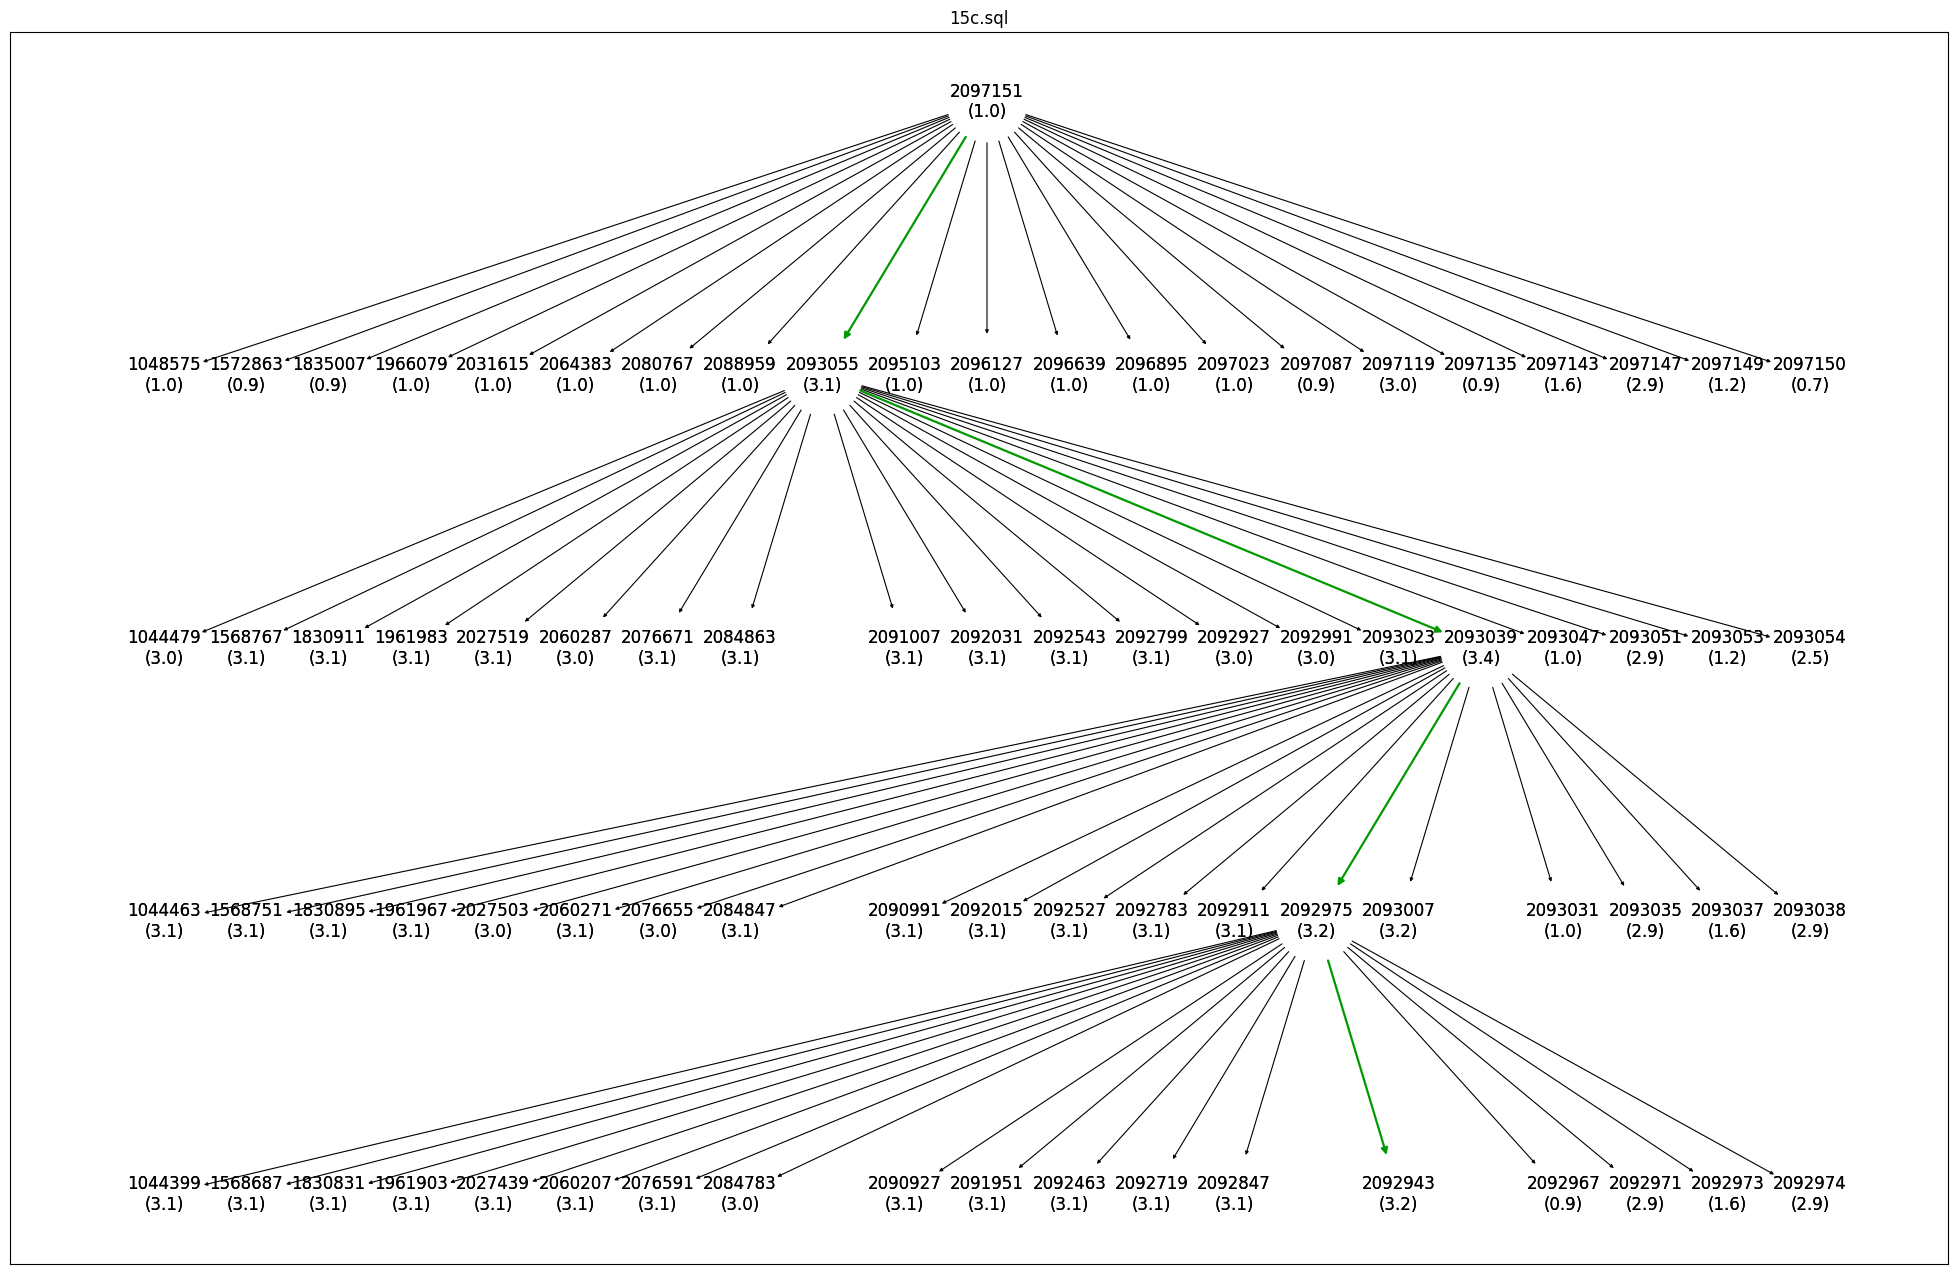

In [249]:
import matplotlib.pyplot as plt
import matplotlib
from fastgres.baseline.utility import zip_and_order
# config = QueryOrderTraversal.EvaluationConfig(1, ["10c.sql"])
# qot.eval_config = config
# order = list(qot.traverse_hint_sets().keys())
# print(order)
query_name = wl.queries[19]
qot.query_names = [query_name]
# print(qot.archive[qot.query_names[0]])
start_hint = 2**len(hints)-1
levels = 4
order = [start_hint]
for i in range(levels):
    one_ring = qot.calculate_one_ring(start_hint)
    times = [qot.archive[query_name][str(_)] for _ in one_ring]
    ordered = zip_and_order(one_ring, times, desc=False)
    best_hint, best_time = ordered[0]
    start_hint = best_hint
    order.append(best_hint)
print(order)

break_level = 4
fig, ax = plt.subplots(figsize=(25, break_level*4))
ax = qot.draw_default(order, ax, break_level=break_level)
ax.set_title(query_name)
matplotlib.rcParams['pdf.use14corefonts'] = True
plt.savefig(f"figures/hint_set_order_vis/all_hints_{query_name}.pdf", bbox_inches="tight")
plt.show()
# eval_config = HintSetOrder.EvaluationConfig(1, wl.queries[:10])
# hso.eval_config = eval_config
# hso.save_results("figures/hint_set_order_vis/all_hints.pdf")
# hso.show()



# Using Hint Removal

In [264]:
from fastgres.baseline.hint_sets import HintSet, PostgresOperator, Hint
workload_name = "job"
version = 16.1
a_path = f"fastgres/archives/{workload_name}/{version}/all_hints_ig.json"
wl_path = f"fastgres/workloads/queries/{workload_name}/"
wl = Workload(wl_path, workload_name)
hints = [Hint[PostgresOperator(op).name] for op in HintSet.all_operators]

In [265]:
import networkx as nx


def draw_graph(ax, draw_variables):
    edges = draw_variables["edges"]
    top_order_edges = draw_variables["top_order_edges"]
    pos = draw_variables["pos"]
    labels = draw_variables["labels"]
    graph = draw_variables["graph"]
    
    for edge in edges:
        if edge in top_order_edges:
            color = "#009900"
            pen_width = 1.6
        else:
            color = "#000000"
            pen_width = 0.8
        graph.add_edge(str(edge[0]), str(edge[1]), color=color, weight=pen_width)

    colors = [graph[u][v]['color'] for u, v in graph.edges()]
    color_map = ['w' for _ in graph]
    weights = [float(graph[u][v]['weight']) for u, v in graph.edges()]
    nx.draw_networkx_nodes(graph, pos=pos, node_color=color_map, label=labels, alpha=0.1,
                           linewidths=0.1, ax=ax)
    index = 0
    for edge in graph.edges(data=True):
        nx.draw_networkx_edges(graph, pos=pos, edgelist=[(edge[0], edge[1])], edge_color=colors[index],
                               arrowsize=weights[index] * 6, width=weights[index], ax=ax, node_size=1750,
                               node_shape="s")
        index += 1
    nx.draw_networkx_labels(graph, pos, ax=ax, labels=labels)
    return ax

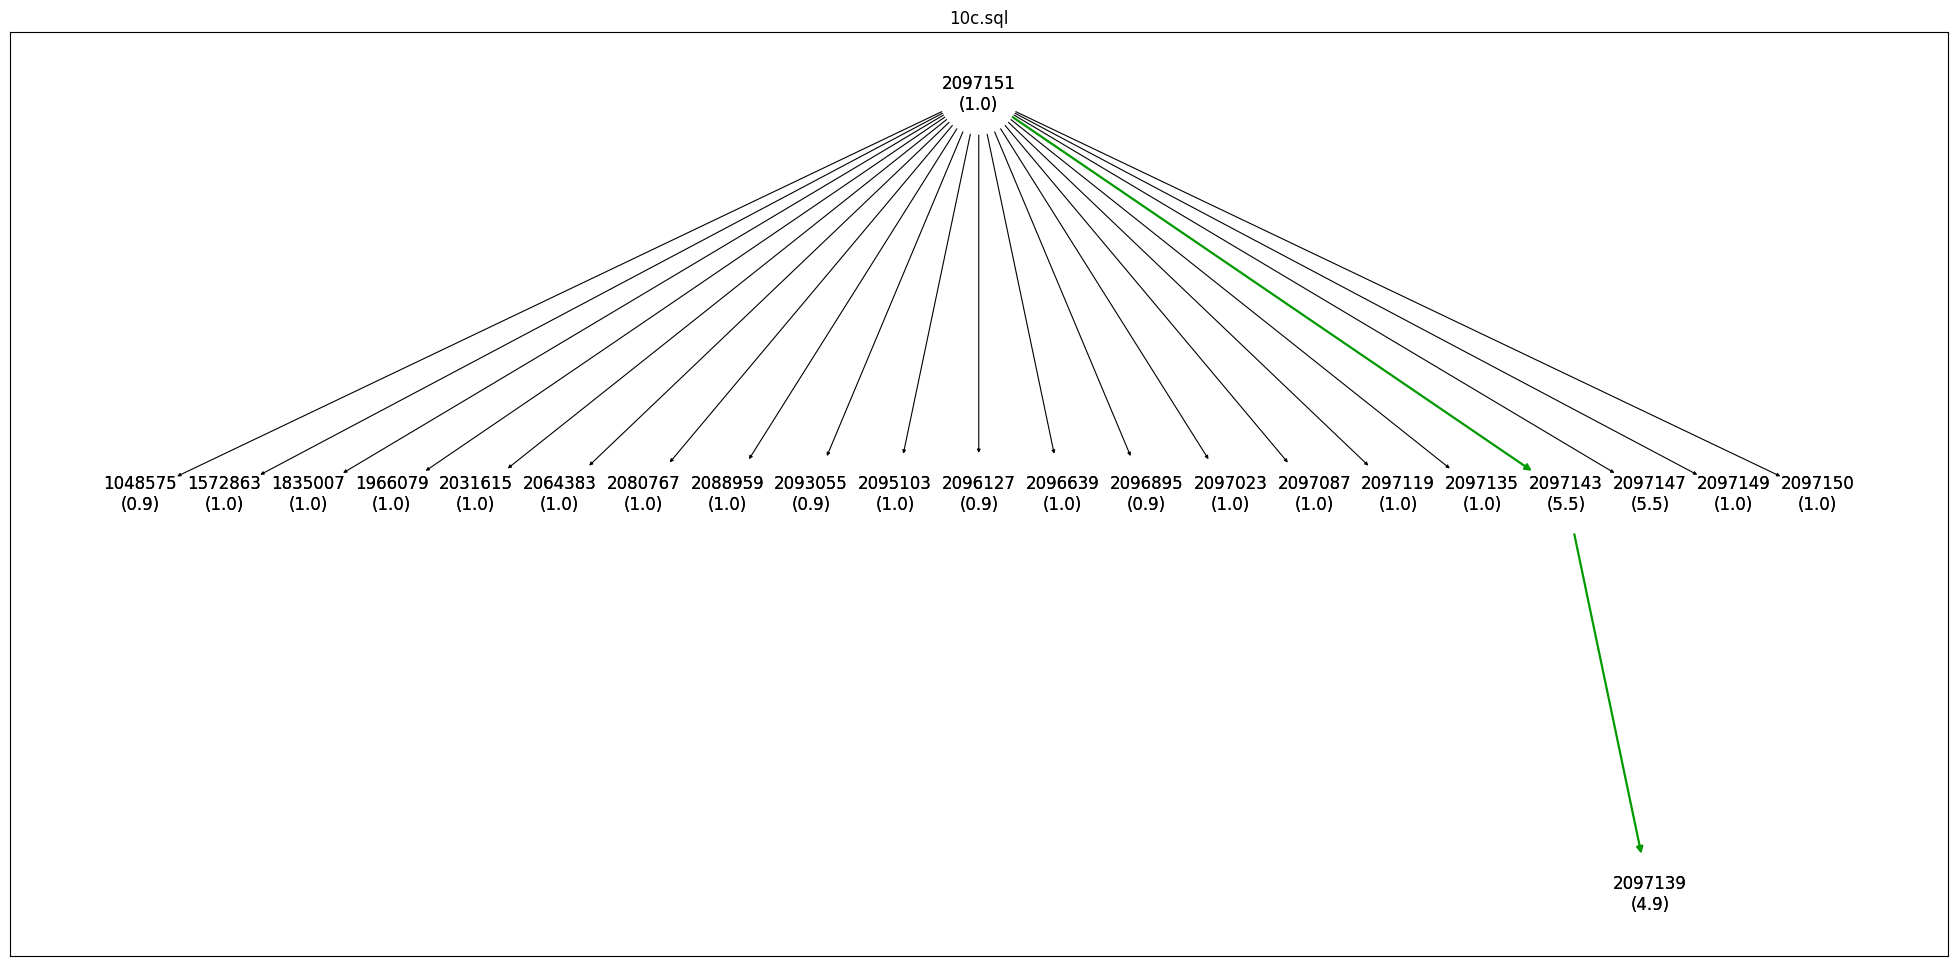

In [268]:

from fastgres.baseline.utility import int_to_binary, get_first_mismatch
from fastgres.analysis_utility.tools.hint_set_order import HintSetOrder
from fastgres.analysis_utility.tools.query_order_traversal import QueryOrderTraversal
from fastgres.analysis_utility import tool
import matplotlib.pyplot as plt
import matplotlib
from fastgres.baseline.utility import zip_and_order
import numpy as np

# query_name = "11c.sql"
qot = QueryOrderTraversal(a_path, wl_path, [query_name], hints, op_mode=QueryOrderTraversal.OperationMode.SUB, use_pseudo_dict=False)

query_name = wl.queries[2]
qot.query_names = [query_name]
# print(qot.archive[qot.query_names[0]])
start_hint = 2**len(hints)-1
levels = 4
order = [start_hint]

def calculate_one_ring_res(archive, one_ring):
    times = list()
    return_items = list()
    for hint_set_int in one_ring:
        try:
            times.append(archive[query_name][str(hint_set_int)])
            return_items.append(hint_set_int)
        except KeyError:
            pass
    return return_items, times

for i in range(levels):
    one_ring = qot.calculate_one_ring(start_hint)
    one_ring, times = calculate_one_ring_res(qot.archive, one_ring)
    if not one_ring:
        break
    ordered = zip_and_order(one_ring, times, desc=False)
    best_hint, best_time = ordered[0]
    start_hint = best_hint
    order.append(best_hint)

edges = set()
default = 2**len(hints)-1
pos = {default: np.array([round((len(hints)-1)/2, 1), 0]),
       str(default): np.array([round((len(hints)-1)/2, 1), 0])}
graph = nx.DiGraph()
labels = {default: f"{str(default)}\n(1.0)", f"{default}": f"{str(default)}\n(1.0)"}
order = [default] + order + [0]
level = 0
# print(qot.archive[query_name])
for level_idx in range(len(order)):
    last_order_item = order[level_idx]
    int_list_last_order = int_to_binary(last_order_item, len(hints))
    one_ring = qot.calculate_one_ring(last_order_item)
    one_ring, time = calculate_one_ring_res(qot.archive, one_ring)
    if not one_ring:
        break
    for i in range(len(one_ring)):
        hint_set = one_ring[i]

        hint_set_int_list = int_to_binary(hint_set, len(hints))
        index = get_first_mismatch(int_list_last_order, hint_set_int_list)

        speedup = np.round(
            tool.get_speedup(tool.get_baseline(qot.archive, [query_name]),
                             np.array([qot.archive[q_name][str(hint_set)] for q_name in [query_name]])), 1)[0]
        pos[hint_set] = np.array([index, -level_idx])
        pos[str(hint_set)] = np.array([index, -level_idx])
        labels[hint_set] = f"{hint_set}\n({speedup})"
        labels[str(hint_set)] = f"{hint_set}\n({speedup})"
        edges.add((last_order_item, hint_set))
        graph.add_node(hint_set, pos=(index, -level_idx))
    level += 1

    if break_level is not None and level_idx >= break_level:
        break
top_order_edges = qot.edges_from_order(tuple(order))
draw_variables = dict()
draw_variables["edges"] = edges
draw_variables["top_order_edges"] = top_order_edges
draw_variables["pos"] = pos
draw_variables["labels"] = labels
draw_variables["graph"] = graph

break_level = 4
fig, ax = plt.subplots(figsize=(25, level*4))
ax = draw_graph(ax, draw_variables)
ax.set_title(query_name)
# matplotlib.rcParams['pdf.use14corefonts'] = True
# plt.savefig(f"figures/hint_set_order_vis/all_hints_{query_name}.pdf", bbox_inches="tight")
plt.show()
# eval_config = HintSetOrder.EvaluationConfig(1, wl.queries[:10])
# hso.eval_config = eval_config
# hso.save_results("figures/hint_set_order_vis/all_hints.pdf")
# hso.show()


In [ ]:
# import graphviz
# import numpy as np
# 
# # c1 = res["level_1"]==47
# # c2 = res["level_2"]==43
# # print(res[c1 & c2])
# 
# factor = 1.0
# reduced_amount = int(factor*len(wl.queries))
# edge_tuples = set()
# count_aggregate = res.groupby(by=levels).count()
# orders = count_aggregate.index.to_numpy()[:reduced_amount]
# occ = count_aggregate["time_0"].to_numpy()[:reduced_amount]
# 
# # max_ind = np.argmax(np.array(occ))
# # max_orders = [orders[max_ind]]
# # max_order_edges = set()
# # for order_pair in max_orders:
# #     for i in range(1, len(order_pair)):
# #         max_order_edges.add((order_pair[i-1], order_pair[i]))
# # # print(orders)
# # # print(occ)
# # level_uniques = [[63]]
# # for level in range(1, len(hints)+1):
# #     level_uniques.append(list(sorted(set(list(res[f"level_{level}"])), reverse=True)))
# # # print(f"Level uniques: {level_uniques}")
# # 
# # for order_pair in orders:
# #     for i in range(1, len(order_pair)):
# #         edge_tuples.add((order_pair[i-1], order_pair[i]))
# # # print(f"Edge tuples: {edge_tuples}")
# # 
# # d = graphviz.Digraph()
# # for level_idx in range(0, len(hints)+1):
# #     with d.subgraph() as s:
# #         s.attr(rank="same")
# #         [d.node(str(unique)) for unique in level_uniques[level_idx]]
# # 
# # for edge in edge_tuples:
# #     if edge in max_order_edges:
# #         color = "green"
# #         pen_width = "5.0"
# #     else:
# #         color = "black"
# #         pen_width = "1.0"
# #     d.edge(str(edge[0]), str(edge[1]), color=color, penwidth=pen_width)
# # 
# # d.view()
# 
# # occurrence sorted index
# idx = [i for i in range(len(occ))]
# sorted_index_tuples = sorted(list(zip(idx, occ)), key=lambda x: x[1], reverse=True)
# sorted_idx = [_[0] for _ in sorted_index_tuples]
# sorted_occ = [_[1] for _ in sorted_index_tuples]
# sorted_orders = [orders[i] for i in sorted_idx]
# # query_names = list(res["query_name"])
# # sorted_queries = [query_names[i] for i in sorted_idx]
# 
# # threshold based index reduction  
# # threshold_value = 1.0
# # threshold = int(threshold_value*len(wl.queries))
# # threshold_indices = [sorted_idx[i] for i in range(len(sorted_idx)) if sum(sorted_occ[:i]) < threshold]
# 
# # calculation of top-k orders
# perc = 0.10
# top_k = int(perc*len(orders))
# top_k = 5
# top_orders = sorted_orders[:top_k]
# top_occ = sorted_occ[:top_k]
# # top_queries = sorted_queries[:top_k]
# # print(res[res["query_name"].isin(top_queries)])
# # [print(top_queries[i], top_orders[i]) for i in range(len(top_queries))]
# print(f"Max Occurrence: {sum(top_occ)} / {len(wl.queries)}")
# # orders = [orders[i] for i in threshold_indices]
# # occ = [occ[i] for i in threshold_indices]
# 
# # calculate optimal hint set within top k orders
# # top_optimal_hints = set()
# # for query_name in top_queries:
# #     # df line
# #     query_entry = res[res["query_name"]== query_name].to_numpy()[0]
# #     # name, hint sets, times -> 1 : levelsize : levelsize
# #     hint_sets = query_entry[1:len(levels)+1]
# #     hint_set_times = query_entry[len(levels)+1:]
# #     # sort by hint set times to find the optimal solution
# #     sorted_hint_sets = sorted(list(zip(hint_sets, hint_set_times)), key=lambda x: x[1])
# #     # take hint set of minimal values
# #     top_optimal_hints.add(sorted_hint_sets[0][0])
# 
# # query_col = list(res["query_name"])
# # threshold_queries = [query_col[i] for i in sorted_idx[:top_k]]
# # reduced_res = res[res["query_name"].isin(threshold_queries)]
# # reduced_res = reduced_res[reduced_res]
# # min_v = reduced_res.loc[:, times].idxmin(axis=1)
# # min_levels = [int(_[-1]) for _ in list(min_v)]
# # print(reduced_res)
# # min_hints = [reduced_res.iloc[i][f"level_{min_levels[i]}"] for i in range(len(min_levels))]
# # print(min_levels)
# # print(min_hints)
# 
# # calculate top k orders to mark
# top_order_edges = set()
# for order_pair in top_orders:
#     for i in range(1, len(order_pair)):
#         top_order_edges.add((order_pair[i-1], order_pair[i]))
# 
# level_uniques = [[63]]
# for level in range(1, len(hints)+1):
#     single_level_uniques = list(set([order[level] for order in orders]))
#     level_uniques.append(single_level_uniques)
# 
# for order_pair in orders:
#     for i in range(1, len(order_pair)):
#         edge_tuples.add((order_pair[i-1], order_pair[i]))
# 
# d = graphviz.Digraph()
# for level_idx in range(0, len(hints)+1):
#     with d.subgraph() as s:
#         s.attr(rank="same")
#         for unique in level_uniques[level_idx]:
#             d.node(str(unique))
#             # if unique in top_optimal_hints:
#             #     d.node(str(unique), color="red")
#             # else:
#             #     d.node(str(unique))
# 
# for edge in edge_tuples:
#     if edge in top_order_edges:
#         color = "green"
#         pen_width = "5.0"
#     else:
#         color = "black"
#         pen_width = "1.0"
#     d.edge(str(edge[0]), str(edge[1]), color=color, penwidth=pen_width)
# 
# d.view()

In [ ]:
# import pandas as pd
# 
# cols = ["query_name"]
# levels = [f"level_{i}" for i in range(len(hints)+1)]
# times = [f"time_{i}" for i in range(len(hints)+1)]
# cols.extend(levels)
# cols.extend(times)
# res = pd.DataFrame(columns=cols)
# traversal = RingNeighborhoodTraversal(a_path, wl_path, [], hints, op_mode=RingNeighborhoodTraversal.OperationMode.SUB, spread=1)
# for query_name in wl.queries:
#     traversal.query_names = [query_name]
#     traversed_hint_sets = traversal.traverse_hint_sets()
#     # order = traversal.traversed_order(traversed_hint_sets)
#     entry = [query_name]
#     entry.extend(list(traversed_hint_sets.keys()))
#     entry.extend(list(traversed_hint_sets.values()))
#     
#     res.loc[len(res.index)] = entry
#     # 
#     # for level_idx in range(1, len(hints)+1):
#     #     key = list(traversed_hint_sets.keys())[level_idx]
#     #     res.loc[len(res.index)] = query_name, level_idx, key, traversed_hint_sets[key]
#     # res[query_name] = {"traversed": traversed_hint_sets, "order": order}
# print(res.head())

In [ ]:
# import networkx as nx
# import matplotlib.pyplot as plt
# graph, pos = h_o.plot()
# colors = [graph[u][v]['color'] for u,v in graph.edges()]
# color_map = ['w' for node in graph]
# labels = [str(node) for node in graph]
# weights = [float(graph[u][v]['weight']) for u,v in graph.edges()]
# nx.draw_networkx_nodes(graph, pos=pos, node_color=color_map, label=labels, alpha=0.1, linewidths=0.1)
# nx.draw_networkx_labels(graph, pos)
# index = 0
# for edge in graph.edges(data=True):
#     nx.draw_networkx_edges(graph, pos=pos, edgelist=[(edge[0], edge[1])], edge_color=colors[index], arrowsize=weights[index]*6, width=weights[index])
#     index += 1
# # nx.draw(graph)
# plt.savefig("figures/hint_set_order_vis/test_0.pdf")
# plt.show()